In this notebook we go over how to use [larcv](https://github.com/DeepLearnPhysics/larcv2)'s dedicated IO interface, `larcv::IOManager` C++ class to browse the file contents. If you are looking for a tutorial to use bare [ROOT](https://root.cern.ch) APIs, checkout [this tutorial](http://deeplearnphysics.org/Blog/tutorials/tutorial-02.html).  That said, here's an outline of what's covered in this notebook.

* [Instantiation of IOManager by hand](#byhand)
* [How to use a configuration text file](#configfile)
* [Browsing the file contents with IOManager](#browsing)
* [What are "_entries_"?](#entries)
* [Accessing an entry with IOManager](#snapshot)
* [Making a brand-new LArCV file](#write)
* [Making a modification/addition to an existing file](#readwrite)
* [Making your IO faster](#readwrite_fast)
* [Closing remark (can ignore)](#closing)


We assume you already set up larcv and cloned [larcv-tutorial](https://github.com/DeepLearnPhysics/larcv-tutorial) repository. If not, checkout our [installation tutorial](https://deeplearnphysics.org/Blog/tutorials/tutorial-01.html). Let's start with the basic imports.

In [2]:
from __future__ import print_function
import ROOT
from larcv import larcv
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

We will use a ROOT file that comes with the tutorial repository.

In [3]:
%%bash
ls ../*.root

../electron.root
../out_v2.root
../proton.root
../sample.root


<a name="byhand"></a>
## Instantiation of IOManager (by hand)
`larcv::IOManager` is [writen in C++](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/IOManager.h) but is accessible from Python. The default constructor creates an instance with two arguments: **`IOMode_t`** and `std::string` indicating the unique name of an instance. The `IOMode_t` is defined in `IOManager` scope as `enum IOMode_t {kREAD, kWRITE, kBOTH}`. You can give either enum expression or value.

In [4]:
io = larcv.IOManager(0,"IOManager") # identical to IOManager(larcv.IOManager.kREAD,"IOManager")
# Add a list of files to read-in (>=1)
io.add_in_file('../proton.root')
io.add_in_file('../electron.root')
# Calling initialize() will open up all files and prepare IO.
# You cannot add more files after initialize() is called.
print('initialize() return:',io.initialize())

initialize() return: True
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../proton.root
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../electron.root
    [NORMAL]  <IOManager::initialize> Prepared input with 20 entries...


The colored messages with `[NORMAL]` prefix are sent from the IOManager instance for the set verbosity level (by default, `NORMAL`, `WARNING`, `ERROR` and `CRITICAL` are shown). You can see that 2 files requested to open are in fact recognized. The total of 20 entries is a stacked sum of events stored in both files. If you are wondering <font color="red">**what does it mean by `entries`??**</font>, we will cover that in [later section](#entries) :).

<a name="configfile"></a>
## Instantiation of IOManager (by configuration file)
You can instantiate IOManager using a configuration text (ASCII) file, too. This may become handy if you prefer a formatted list of many configuration options (which we have not explored yet). Here's an example.

In [5]:
io_config = \
"""
IOManager: {
  IOMode:    0
  Verbosity: 2
  InputFiles:   ["../proton.root","../electron.root"]
}
"""

import tempfile
test_io_config = tempfile.NamedTemporaryFile('w')
test_io_config.write(io_config)
test_io_config.flush()

io=larcv.IOManager(test_io_config.name)
io.initialize()

True

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../proton.root
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../electron.root
    [NORMAL]  <IOManager::initialize> Prepared input with 20 entries...


The verbsoity levels are also set by an `enum` [defined here](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/Base/LArCVTypes.h#L58). `NORMAL` corresponds to the enum value 2. If you would like to see more detailed output, you can set it to a lower value. But we won't try this in this jupyter notebook since the text output can overwhelm the kernel. If you would like to, try it in a plain python script by changing the `Verbosity` parameter value in the above configuration example to 1.

<a name="browsing"></a>
## Browsing the contents
Once we opened a file, next we want to browse the contents. There are few useful functions to get the file _meta_ (i.e. summary) data.

In [6]:
# Get a list of opened files
print('Listing files opened...')
for count, name in enumerate(io.file_list()):
    print('  file {:d}: {:s}'.format(count,name))
# Get number of entries in the file
print('\nNumber of entries:', io.get_n_entries())
# Get a list of data products stored
print('\nListing data products stored...')
for name in io.product_list():
    print('  product type:\033[91m',name,'\033[00m')

Listing files opened...
  file 0: ../proton.root
  file 1: ../electron.root

Number of entries: 20

Listing data products stored...
  product type: image2d 
  product type: particle 


The last function, `IOManager::product_list()`, is useful to know the list of data product types found (i.e. available) in the files (don't be distracted by `\033[91m` and such: that's just me preferring to color-highlighting the printed message). The function returns a list of strings where each string is a unique identifier for a certain data product type. For example, `image2d` refers to `larcv::EventImage2D` data product. To learn about the list of data products, you can [read here](https://github.com/DeepLearnPhysics/larcv2/wiki/Data-Product). 

Now, in the file, you may have more than one _instance_ of a certain product type. For example, maybe Kazu decided to store EventImage2D (= just 2D image) of his daughter while Corey insists to store his daughter's image. LArCV supports both fathers' request to co-exist in the file by assigning a unique instance _label_ which is also a string. In other words, in larcv file, a unique data product instance is identified by a combination of two strings: **product type** and **instance label** where the latter is also called _producer label_ sometimes. Here is how to list a list of available instance labels in the file.

In [7]:
msg = 'product found... type: "\033[91m{:s}\033[00m" ... label "\033[94m{:s}\033[00m"'
for product_type in io.product_list():
    for instance_label in io.producer_list(product_type):
        print(msg.format(product_type,instance_label))

product found... type: "image2d" ... label "data"
product found... type: "particle" ... label "mctruth"


Just in case you did not checkout a more basic tutorial on [using bare ROOT APIs](http://deeplearnphysics.org/Blog/tutorials/tutorial-02.html), this information can also be retrieved simply by:

In [8]:
ROOT.TFile.Open('../electron.root','READ').ls()

TFile**		../electron.root	
 TFile*		../electron.root	
  KEY: TTree	particle_mctruth_tree;1	mctruth tree
  KEY: TTree	image2d_data_tree;1	data tree


... which lists bare [TTree](https://root.cern.ch/doc/master/classTTree.html) names that encodes two strings of our interest: data product type and instance label.

<a name="entries"></a>
## _Entries_: structure of data in file
In the [first example](#byhand) of opening a file in this notebook, we postponeded to discuss what "entries" mean. If you are from high energy physics community and familiar with ROOT, you can certainly skip this section. 
* Each data product instance (identified by a type and label) is stored in a dedicated ROOT TTree
* Each TTree entry stores attribute values' snapshot at the moment when data is recorded.

For instance, say we create an instance of EventImage2D to store 2D image in file. Let's say we filled this instance with an image of Kazu's daughter, and stored this _snapshot_. Then we re-filled the data product instance with an image of Corey's daughter, and again called the relevant function to store this _snapshot_. In this sequence of actions, <font color="blue">TTree is filled with _two entries_</font> while there is <font color="blue">only one data product instance _uniquely identified by the type and label strings_</font>. This is how data is stored in larcv file.

Finally one more important point to be noted:
* Entries across TTrees are aligned. This means the same entry of different TTrees (i.e. data product instances) correspond to the same _event_.

Individual data product instance stores an aspect of an _event_, a word that refers to single instance of physical phenomenon happening. You may have as _many_ data products as you need to record the full details of physics phenomenon. To make this possible, we need all data product's snapshot to be _aligned_ so that we know which snapshot (i.e. data values) correspond to each other. This is achieved by using TTree's entry index number as a unique identifier of an event, and therefore the statement, "entries across TTrees are aligned."

<a name="snapshot"></a>
## Accessing TTree entry (i.e. snapshot of data)
In order to access a certain entry, you can use `IOManager::read_entry` function.

In [9]:
# Access entry 0
io.read_entry(0)
# Access a product instance (type,label) = (image2d,data)
image2d_data = io.get_data("image2d","data")
print("Retrieved data snapshot",image2d_data)

Retrieved data snapshot <ROOT.larcv::EventImage2D object at 0x7fcd797719e0>


Once entry is specified, `IOManager::get_data` function can be used to retrieve the data product instance filled with the snapshot value (i.e. entry=0). In this case the resulting object is `larcv::EventImage2D` C++ object exposed to python. You can call any attribute function defined in C++ to interact with the instance.

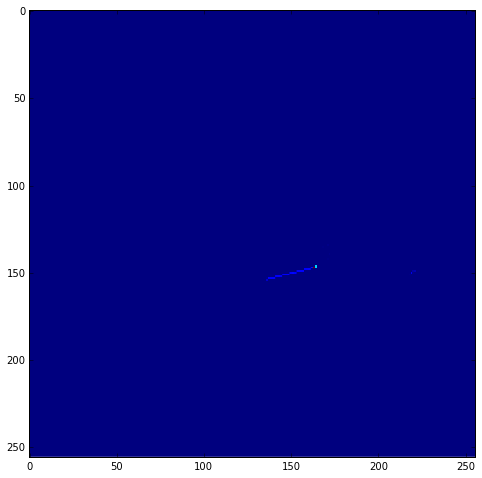

In [10]:
numpy_image = larcv.as_ndarray(image2d_data.as_vector().front())
fig = plt.figure(figsize=(8,8))
plt.imshow(numpy_image, interpolation='none',cmap='jet')
plt.show()

_What is this image??_ Remember we have another data product type `particle`, and that records a type of particle stored in the same event.

In [11]:
particle_data = io.get_data("particle","mctruth")
print("PDG Code:",particle_data.as_vector().front().pdg_code())

PDG Code: 2212


where [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf) 2212 corresponds to a proton. So this is a 2D projection of a proton's trajectory!

<a name="write"></a>
## Creating a new larcv file
When you don't need to read an existing file but want to create a new file to store brandnew events, all you need to change is the `IOMode_t` to construct an IOManager instance.

In [12]:
io = larcv.IOManager(1,"IOManager") # identical to IOManager(larcv.IOManager.kWRITE,"IOManager")
# Set the output file name
io.set_out_file('remove_me.root')
# Calling initialize() will prepare IO.
# You cannot change output file name after initialize() is called.
print('initialize() return:',io.initialize())


initialize() return: True


Or, equivalently using a configuration file:

In [13]:
io_config = \
"""
IOManager: {
  IOMode:    1
  Verbosity: 2
  OutFileName: "remove_me.root"
}
"""

import tempfile
test_io_config = tempfile.NamedTemporaryFile('w')
test_io_config.write(io_config)
test_io_config.flush()

io=larcv.IOManager(test_io_config.name)
io.initialize()

True

Let's create something, and close (i.e. store) the output file. In order to create a new data product, you can use the exact same function `IOManager::get_data` we used earlier. This function, when you instantiate IOManager with `kWRITE` mode, creates a new data product instance if you have not yet created. Here is an example of creating 3 entries and closing the file.

In [14]:
for entry in xrange(3):
    print('Recording entry',entry)
    my_particle = io.get_data('particle','toy')
    io.set_id(0,0,entry)
    io.save_entry()
io.finalize()

Recording entry 0
Recording entry 1
Recording entry 2
    [NORMAL]  <IOManager::get_data> Created TTree particle_toy_tree (id=0) w/ 0 entries...
    [NORMAL]  <IOManager::finalize> Writing particle_toy_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Closing output file


As you can tell, for this minimal example, I did not fill any data attributes. However I note two important function calls: `IOManager::set_id` and `IOManager::save_entry()`. The latter is very self-descriptive: it saves a snapshot of all created data product instances. The former is often forgotten! so it is important to note. `IOManager::set_id` function is used to set a unique identifier for TTree _entry_. 

You might argue **"Why not using an integer entry index number?"** and that's a good point! That's because sometimes (actually often) we want to uniquely identify an entry, or _physics event_, across different files. TTree entry indexes, which is 0 or positive integers, are only useful to identify a unique entry within a file. For this purpose, larcv uses a combination of 3 integer attributes called `run`, `subrun`, and `event`. These are _forced_, common attributes to all larcv data product types since they are used to align data products uniquely. As long as they are unique, they can be of any value combinations. <font color="blue">You may define the meaning of these attributes for your own convenience.</font> For instance, you may vary `run` and `event` and keep `subrun` always the same value like 0.

Lastly, let's make sure we can read-in this file!

In [15]:
io = larcv.IOManager(0,"IOManager")
io.add_in_file('remove_me.root')
io.initialize()

# Get a list of opened files
print('Listing files opened...')
for count, name in enumerate(io.file_list()):
    print('  file {:d}: {:s}'.format(count,name))
# Get number of entries in the file
print('\nNumber of entries:', io.get_n_entries())
# Get a list of data products stored
print('\nListing data products stored...')
for name in io.product_list():
    print('  product type:\033[91m',name,'\033[00m')

Listing files opened...
  file 0: remove_me.root

Number of entries: 3

Listing data products stored...
  product type: particle 
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: remove_me.root
    [NORMAL]  <IOManager::initialize> Prepared input with 3 entries...


<a name="readwrite"></a>
## Making modification/addition to existing file
The last example case of IOManager use is _read-and-write_ which uses `IOMode_t` enum value 2, or `kBOTH` symbol. Again you can do either interactively:

In [16]:
io = larcv.IOManager(2,"IOManager") # identical to IOManager(larcv.IOManager.kWRITE,"IOManager")
# Add a list of input files
io.add_in_file('../proton.root')
io.add_in_file('../electron.root')
# Set the output file name
io.set_out_file('remove_me.root')
# Initialize
print('initialize() return:',io.initialize())

initialize() return: True
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../proton.root
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../electron.root
    [NORMAL]  <IOManager::initialize> Prepared input with 20 entries...


... or using a configuration file:

In [17]:
io_config = \
"""
IOManager: {
  IOMode:    2
  Verbosity: 2
  InputFiles:  ["../proton.root","../electron.root"]
  OutFileName: "remove_me.root"
}
"""

import tempfile
test_io_config = tempfile.NamedTemporaryFile('w')
test_io_config.write(io_config)
test_io_config.flush()

io=larcv.IOManager(test_io_config.name)
io.initialize()

True

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../proton.root
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../electron.root
    [NORMAL]  <IOManager::initialize> Prepared input with 20 entries...


Create 3 toy data product instances per event and store.

In [18]:
%%time

for entry in xrange(3):
    io.read_entry(entry)
    oiriginal = io.get_data('particle','mctruth')
    mine      = io.get_data('particle','toy')
    io.save_entry()
io.finalize()

CPU times: user 13.8 ms, sys: 3.22 ms, total: 17 ms
Wall time: 17.3 ms
    [NORMAL]  <IOManager::get_data> Created TTree particle_toy_tree (id=2) w/ 0 entries...
    [NORMAL]  <IOManager::finalize> Writing particle_mctruth_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Writing image2d_data_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Writing particle_toy_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Closing output file


You may have noticed, in this example, we did not call `IOManager::set_id()` function. This is because it was not necessary. You see we first called `oiriginal = io.get_data('particle','mctruth')`. When this is executed, IOManager reads-in this data product from the disk, and fetch (`run`,`subrun`,`event`) data from this data product. Then this combination of integers are used as the default _event identifier key_ for newly created data product (the next line). Of course, if you would like to, you can still over-ride this combination by calling `IOManager::set_id` explicitly.

<a name="readwrite_fast"></a>
## _Fast_ Read/Write
You may have noticed, in the last code block we executed, `IOManager::finalize` reported that 3 TTrees are written: `particle_mctruth_tree`, `image2d_data_tree`, and `particle_toy_tree` where the last one is what we added. This shows you that the `kBOTH` mode by default **reads and writes _all_ data products**. But this is not always what you want to do, and it may slow down your IO by doing extra read/write. Sometimes you want to read a _subset_ of input, and write out a (possibly different) subset to the output. You can do this by specifying a list of data products to be read-in and write-out separately.

In [19]:
io_config = \
"""
IOManager: {
  IOMode:    2
  Verbosity: 2
  InputFiles:    ["../proton.root","../electron.root"]
  OutFileName:   "remove_me.root"
  ReadOnlyType:  ["particle"]
  ReadOnlyName:  ["mctruth"]
  WriteOnlyType: ["particle","particle"]
  WriteOnlyName: ["toy","mctruth"]
}
"""

import tempfile
test_io_config = tempfile.NamedTemporaryFile('w')
test_io_config.write(io_config)
test_io_config.flush()

io=larcv.IOManager(test_io_config.name)
io.initialize()

True

    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../proton.root
    [NORMAL]  <IOManager::prepare_input> Skipping: producer=data type= image2d
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: ../electron.root
    [NORMAL]  <IOManager::prepare_input> Skipping: producer=data type= image2d
    [NORMAL]  <IOManager::initialize> Prepared input with 20 entries...


Note the additional configuration parameters, `ReadOnlyName`, `ReadOnlyType`, `WriteOnlyName`, and `WriteOnlyType`. These should be the array of strings specifying a list of data product types and labels to read/write. The order of strings should be matching for ReadOnly and WriteOnly parameters.

In the resulting output, first, you notice IOManager reports it skipped reading data product type `image2d` with label `data` as we configured!

In [20]:
%%time
for entry in xrange(3):
    io.read_entry(entry)
    oiriginal = io.get_data('particle','mctruth')
    mine      = io.get_data('particle','toy')
    io.save_entry()
io.finalize()

CPU times: user 4.46 ms, sys: 1.57 ms, total: 6.04 ms
Wall time: 6.32 ms
    [NORMAL]  <IOManager::get_data> Created TTree particle_toy_tree (id=1) w/ 0 entries...
    [NORMAL]  <IOManager::finalize> Writing particle_mctruth_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Writing particle_toy_tree with 3 entries
    [NORMAL]  <IOManager::finalize> Closing output file


Comparing the measured CPU and wall time in the cell just above this to the one we previously executed without avoiding to read/write `image2d` data product, you can see we gained a significant speed up. Use a combination of ReadOnlyX and WriteOnlyX whenever appropriate for your use of IOManager!

<a name="closing"></a>
## Closing remark
In this notebook we covered how to use larcv's C++ file handler called IOManager. Please note, for browsing files interactively, this is a complementary approach to using bare ROOT APIs. Both methods are useful. However you IOManager is the IO interface used for programming larcv _modules_, which you will eventually see if you are following larcv wiki/manual!